In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from nltk import FreqDist
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from scipy.spatial.distance import cdist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Embedding,Bidirectional,Dropout
from tensorflow.python.keras.optimizers import Adam,SGD
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from sklearn.metrics import roc_auc_score
import csv
from sklearn.model_selection import train_test_split
import nltk
import re

Using TensorFlow backend.


In [2]:
#extract data from amazon.com
#load data from csv file
dataset=pd.read_csv('ourdata2.csv')
dataset3=pd.read_csv('ourdata3.csv')
dataset4=pd.read_csv('ourdata4.csv')
dataset5=pd.read_csv('ourdata5.csv')
dataset6=pd.read_csv('ourdata6.csv')
dataset7=pd.read_csv('ourdata7.csv')
dataset8=pd.read_csv('ourdata8.csv')
dataset9=pd.read_csv('ourdata9.csv')
dataset10=pd.read_csv('ourdata10.csv')
dataset=dataset.append(dataset3)
dataset=dataset.append(dataset4)
dataset=dataset.append(dataset5)
dataset=dataset.append(dataset6)
dataset=dataset.append(dataset7)
dataset=dataset.append(dataset8)
dataset=dataset.append(dataset9)
dataset=dataset.append(dataset10)


C:\Users\Imen\Downloads\WPy-3662\python-3.6.6.amd64\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
linee=[]
for line in dataset['review_text']:
    if line[1]=="'":
        linee.append(line.replace("['",' '))
    elif line[1]=='"':
        linee.append(line.replace('["',' ')) 
    else:
        linee.append(line)
linee1=[]
for line in linee:
    linee1.append(line.replace("']",' '))
linee2=[]
for line in linee1:
    linee2.append(line.replace('"]',' ')) 
dataset['review_text']=linee2
linee=[]
for line in dataset['title']:
    if line[1]=="'":
        linee.append(line.replace("['",' '))
    elif line[1]=='"':
        linee.append(line.replace('["',' ')) 
    else:
        linee.append(line)
linee1=[]
for line in linee:
    linee1.append(line.replace("']",' '))
linee2=[]
for line in linee1:
    linee2.append(line.replace('"]',' ')) 
dataset['title']=linee2
dataset=dataset.drop(['Unnamed: 0'],axis=1)

#join title and review text
dataset['reviews'] = dataset[['title', 'review_text']].apply(lambda x: ''.join(x), axis=1)
dataset['reviews']=dataset['reviews']+'°'
dataset=dataset.drop(['review_text'],axis=1)
dataset=dataset.drop(['title'],axis=1)
splitter=[]
listt=[]
for rate in dataset['rating']:
    splitter.append(rate.split(' '))
for rate in splitter:
    listt.append((list(rate[0]))[2])
dataset['rating']=listt

#now our dataset is ready , we start data preprocessing

# Remove any 'neutral' ratings equal to 3
Neutral = dataset[dataset['rating'] == '3']
#dataset = dataset[dataset['rating'] != '3']
dataset_pos = dataset[dataset['rating'] > '3']
dataset_pos['rating']=1
dataset_neg = dataset[dataset['rating'] < '3']
dataset_neg['rating']=0
dataset_pos1=[]
k=0
for i in dataset_pos['reviews']:
    if k<len(dataset_neg):
        dataset_pos1.append(i)
    k+=1
pos_label=[]
k=0
for i in dataset_pos['rating']:
    if k<len(dataset_neg):
        pos_label.append(i)
    k+=1
dataset_neg1=[]
k=0
for i in dataset_neg['reviews']:
    if k<len(dataset_neg):
        dataset_neg1.append(i)
    k+=1
neg_label=[]
k=0
for i in dataset_neg['rating']:
    if k<len(dataset_neg):
        neg_label.append(i)
    k+=1
label=pos_label+neg_label
data1=dataset_pos1+dataset_neg1


C:\Users\Imen\Downloads\WPy-3662\python-3.6.6.amd64\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Imen\Downloads\WPy-3662\python-3.6.6.amd64\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data1, label, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)

In [5]:
hors_stop_words=['against','between','before','after','above','below','up','down','over','under','again','all','any','both','each','few',
 'more','most','some','no','nor','not','same','so','too','very',"don't",'should',"should've",'ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'mightn', "mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list=list(stopword_list)
for i in hors_stop_words:
    stopword_list.remove(i)

In [6]:
tokenizer1=nltk.tokenize.TreebankWordTokenizer()
#function lower_case
def treat_test_train(X):
    tokens=[]
    for sentence in X:
        sentence_lowercase=sentence.lower()
        tokens.append(tokenizer1.tokenize(sentence_lowercase))
    filtered_words = [] 
    for t in tokens:
        for w in t:
            if w not in stopword_list:
                filtered_words.append(w)
    WNlemma = nltk.WordNetLemmatizer()
    filtered_words=[WNlemma.lemmatize(t) for t in filtered_words]
    textofreviews=' '.join(filtered_words)
    splited=textofreviews.split('°')
    listt=[]
    for sentence in splited: 
        listt.append(re.sub(r'\W+', ' ', sentence))
    tokens2=[]
    for sentence in listt:
        tokens2.append(tokenizer1.tokenize(sentence))
    listt=[]
    for t in tokens2:
        listt.append(' '.join(t))
    splited=listt
    text=list(splited)
    return text

In [7]:
X_test=treat_test_train(X_test)
X_test.remove(X_test[360])
X_train=treat_test_train(X_train)
X_train.remove(X_train[1078])
X_val=treat_test_train(X_val)
X_val.remove(X_val[360])

data= X_train + X_test+X_val

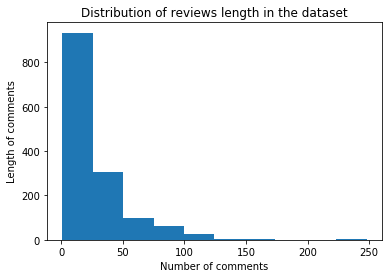

In [8]:
num_words = 100000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data)
#tokenizer.word_index
x_train_tokens = tokenizer.texts_to_sequences(X_train)
x_test_tokens = tokenizer.texts_to_sequences(X_test)
x_val_tokens = tokenizer.texts_to_sequences(X_val)
#☻padding and truncating data
# count the number of tokens in all the sequences in the data-set.
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)
pyplot.hist(num_tokens)
plt.title('Distribution of reviews length in the dataset')
plt.ylabel('Length of comments')
plt.xlabel('Number of comments')
plt.show()

In [9]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)

In [10]:
pad = 'post'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
x_val_pad = pad_sequences(x_val_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

In [11]:
model = Sequential()
embedding_size =8
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
model.add(Bidirectional(LSTM(70,recurrent_dropout=0.5,dropout=0.5)))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
#model.load_weights(filepath)
history=model.fit(x_train_pad, y_train,validation_data=(x_val_pad, y_val), epochs=10, batch_size=10)

C:\Users\Imen\Downloads\WPy-3662\python-3.6.6.amd64\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1078 samples, validate on 360 samples
Epoch 1/10
1078/1078 [==============================] - 15s 14ms/step - loss: 0.6885 - acc: 0.5714 - val_loss: 0.6652 - val_acc: 0.8500
Epoch 2/10
1078/1078 [==============================] - 12s 11ms/step - loss: 0.5527 - acc: 0.8293 - val_loss: 0.3767 - val_acc: 0.8639
Epoch 3/10
1078/1078 [==============================] - 12s 12ms/step - loss: 0.3758 - acc: 0.8766 - val_loss: 0.2952 - val_acc: 0.8778
Epoch 4/10
1078/1078 [==============================] - 12s 11ms/step - loss: 0.2373 - acc: 0.9267 - val_loss: 0.2337 - val_acc: 0.9056
Epoch 5/10
1078/1078 [==============================] - 12s 11ms/step - loss: 0.1891 - acc: 0.9378 - val_loss: 0.2141 - val_acc: 0.9139
Epoch 6/10
1078/1078 [==============================] - 12s 11ms/step - loss: 0.1450 - acc: 0.9564 - val_loss: 0.1971 - val_acc: 0.9250
Epoch 7/10
1078/1078 [==============================] - 12s 11ms/step - loss: 0.1122 - acc: 0.9740 - val_loss: 0.2004 - val_acc: 0.9167
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


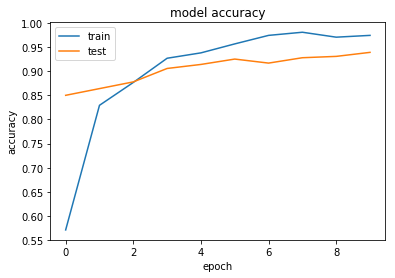

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

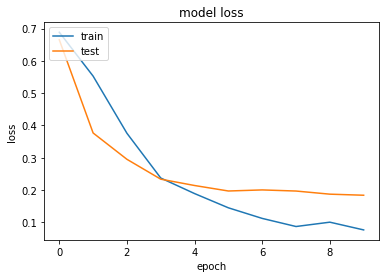

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
y_pred = model.predict(x=x_test_pad)
print('AUC: ', roc_auc_score(y_test, y_pred))
test=pd.read_csv('Comments_Facebook_mascara.csv')
test=test.drop(['Unnamed: 0'],axis=1)
tt=[]
for t in test['0']:
    tt.append(t)


AUC:  0.986601216387268


In [17]:
tokens = tokenizer.texts_to_sequences(tt)
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
pred = np.where(model.predict(tokens_pad) > 0.5, 1, 0)
neg=0
pos=0
for i in pred:
    if i==0:
        neg+=1
    else:
        pos+=1
pred

array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
    

In [99]:
percentage_pos=pos*100/(pos+neg)
percentage_neg=neg*100/(pos+neg)
print("pourcentage des commentaires positives à propos X fiber mascara dans Facebook= " , percentage_pos , "%")
print("pourcentage des commentaires négatives à propos X fiber mascara dans Facebook= " ,percentage_neg , "%")


pourcentage des commentaires positives à propos X fiber mascara dans Facebook=  50.2092050209205 %
pourcentage des commentaires négatives à propos X fiber mascara dans Facebook=  49.7907949790795 %


In [27]:
test_youtube=pd.read_table('Comments_youtube_mascara.csv',encoding='latin1')
list_test_youtube=[]
for i in test_youtube['Summary']:
    list_test_youtube.append(i)
tokens = tokenizer.texts_to_sequences(list_test_youtube)
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
pred = np.where(model.predict(tokens_pad) > 0.5, 1, 0)
neg=0
pos=0
for i in pred:
    if i==0:
        neg+=1
    else:
        pos+=1
pred

array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]])